<a href="https://colab.research.google.com/github/SLCFLAB/Fintech2024-1/blob/main/DL_day11/11_2_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Prediction with Deep Learning Models

You will now practice using deep learning models(Transformer, LSTM) to predict future values using past values. For your assignment, please change parameters, model structures and apply new model to shampoo data.

Reference:
* https://github.com/hee9joon/Univariate-Time-Series-Prediction-using-Deep-Learning.   
*  https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb

## Download Dataset

In [1]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv

--2024-06-11 01:41:01--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519 [text/plain]
Saving to: ‘shampoo.csv’

shampoo.csv         100%[===================>]     519  --.-KB/s    in 0s      

2024-06-11 01:41:02 (24.2 MB/s) - ‘shampoo.csv’ saved [519/519]



In [2]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2024-06-11 01:41:02--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2180 (2.1K) [text/plain]
Saving to: ‘airline-passengers.csv’

airline-passengers. 100%[===================>]   2.13K  --.-KB/s    in 0s      

2024-06-11 01:41:02 (36.6 MB/s) - ‘airline-passengers.csv’ saved [2180/2180]



## Library

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Data Plot

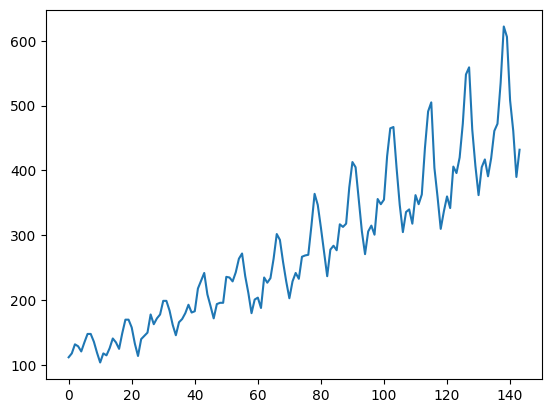

In [4]:
training_set = pd.read_csv('airline-passengers.csv')
#training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

## Dataloading

In [5]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Model

In [12]:
class AttentionBlock(nn.Module):
    def __init__(self, input_dim):
        super(AttentionBlock, self).__init__()
        self.input_dim = input_dim
        self.n_heads = 4
        self.outlinear = nn.Linear(input_dim,input_dim)
        self.dropout = nn.Dropout(0.1)
        self.flatten = nn.Flatten(start_dim=-2)
    def forward(self, q, k, v):
        B, L = q.shape
        query = q.view(B, L//self.n_heads, self.n_heads)
        key = k.view(B, L//self.n_heads, self.n_heads)
        value = v.view(B, L//self.n_heads, self.n_heads)
        scale = 1. / 2
        scores = torch.einsum("ble,bse->bls",query,key)
        A = torch.softmax(scale * scores, dim=-1)
        #A = self.dropout(A)
        V = torch.einsum("bls,bsd->bld", A, value)
        out = self.flatten(V)
        return out#self.outlinear(out) ##

class EncoderBlock(nn.Module):
    def __init__(self, input_dim):
        super(EncoderBlock, self).__init__()
        self.input_dim = input_dim
        self.linear1 = nn.Linear(self.input_dim, 2*self.input_dim)
        self.linear2 = nn.Linear(2*self.input_dim, self.input_dim)
        self.norm1 = nn.LayerNorm(self.input_dim)
        self.norm2 = nn.LayerNorm(self.input_dim)
        self.dropout = nn.Dropout(0.1)
        self.attn = AttentionBlock(self.input_dim)
        self.relu = nn.ReLU(inplace=True)
    def forward(self, x):
        new_x = self.attn(x,x,x)
        x = x + self.dropout(new_x)
        y = x = self.norm1(x)
        y = self.linear1(y)
        y = self.relu(y)
        y = self.linear2(y)
        y = self.dropout(y) ##
        out = self.norm2(x+y)
        return out

class Transformer(nn.Module):
    def __init__(self, input_dim, emb_dim, out_dim, num_encoder):
        super().__init__()
        self.input_layer = nn.Linear(input_dim, emb_dim, bias=True)
        self.encoder_layers = nn.ModuleList([])
        for i in range(num_encoder):
            self.encoder_layers.append(EncoderBlock(emb_dim))
        self.output_layer = nn.Linear(emb_dim, out_dim, bias=True)
    def forward(self, x):
        x = self.input_layer(x)
        for l in self.encoder_layers:
            x = l(x)
        x = self.output_layer(x)
        return x

In [ ]:
class LSTM(nn.Module):
    # Long Short Term Memory
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()

        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))

        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        h_out = h_out.view(-1, self.hidden_size)

        out = self.fc(h_out)

        return out

## Training

In [21]:
num_epochs = 2000
learning_rate = 0.001

input_size = 4
embed_size = 64
num_layers = 1

output_size = 1

model = Transformer(input_size, embed_size, output_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)
# Train the model
for epoch in range(num_epochs):
    outputs = model(trainX[:,:,0])
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.07038
Epoch: 100, loss: 0.00381
Epoch: 200, loss: 0.00212
Epoch: 300, loss: 0.00221
Epoch: 400, loss: 0.00227
Epoch: 500, loss: 0.00187
Epoch: 600, loss: 0.00171
Epoch: 700, loss: 0.00156
Epoch: 800, loss: 0.00159
Epoch: 900, loss: 0.00139
Epoch: 1000, loss: 0.00151
Epoch: 1100, loss: 0.00153
Epoch: 1200, loss: 0.00154
Epoch: 1300, loss: 0.00150
Epoch: 1400, loss: 0.00162
Epoch: 1500, loss: 0.00111
Epoch: 1600, loss: 0.00097
Epoch: 1700, loss: 0.00099
Epoch: 1800, loss: 0.00110
Epoch: 1900, loss: 0.00099


In [ ]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()

    # obtain the loss function
    loss = criterion(outputs, trainY)

    loss.backward()

    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.17601
Epoch: 100, loss: 0.01429
Epoch: 200, loss: 0.00300
Epoch: 300, loss: 0.00263
Epoch: 400, loss: 0.00226
Epoch: 500, loss: 0.00199
Epoch: 600, loss: 0.00183
Epoch: 700, loss: 0.00176
Epoch: 800, loss: 0.00174
Epoch: 900, loss: 0.00174
Epoch: 1000, loss: 0.00173
Epoch: 1100, loss: 0.00173
Epoch: 1200, loss: 0.00172
Epoch: 1300, loss: 0.00172
Epoch: 1400, loss: 0.00172
Epoch: 1500, loss: 0.00171
Epoch: 1600, loss: 0.00171
Epoch: 1700, loss: 0.00171
Epoch: 1800, loss: 0.00171
Epoch: 1900, loss: 0.00170


## Testing for Airplane Passengers Dataset

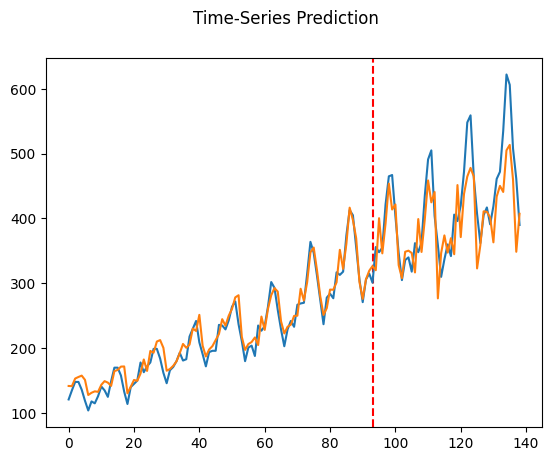

In [22]:
model.eval()
train_predict = model(dataX[:,:,0])

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

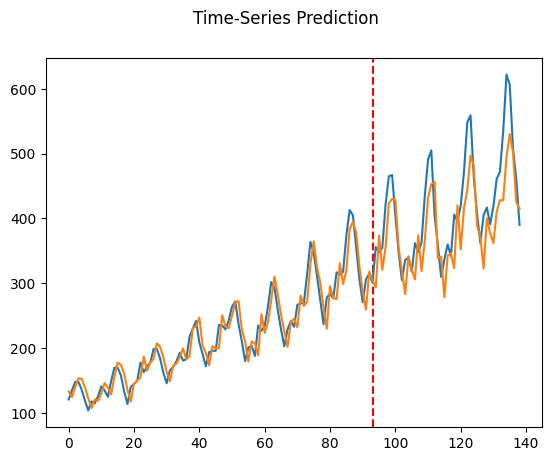

In [ ]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()